# Implementing t-SNE using NUMPY

## Dependencies

In [30]:
!pip install scikit-learn matplotlib
!pip install scipy

In [79]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

## Loading the Dataset

In [6]:
# MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"].astype(int)

# Using only a subset of the dataset to help compute faster
X = X[:5000]
y = y[:5000]

# Normalize the data
X = X / 255.0  # Greyscale 0 - 255

## Pre-existing Methodologies

### t-SNE using scikit-learn

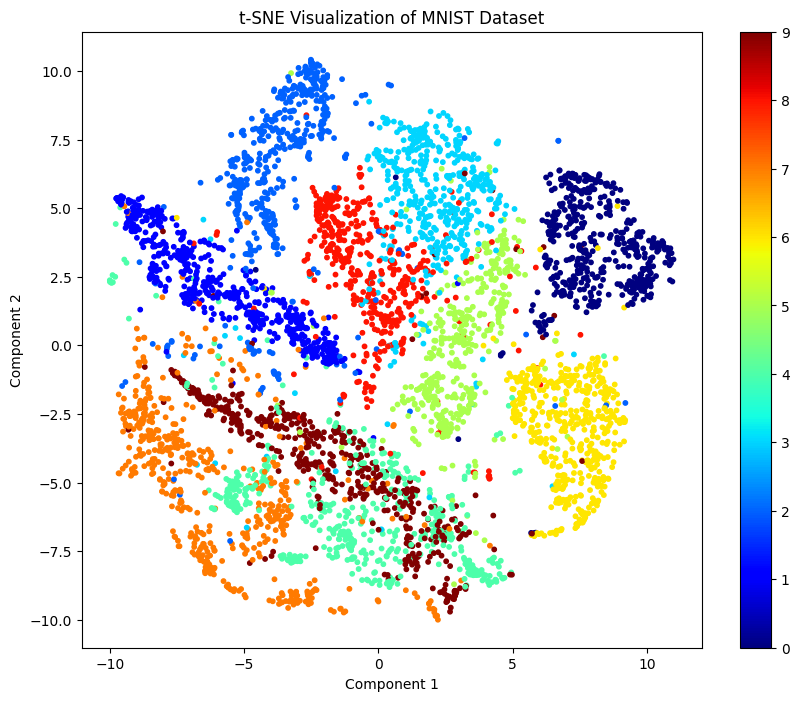

In [10]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
X_embedded = tsne.fit_transform(X)

# Visualizing
plt.figure(figsize=(10, 8))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='jet', s=10)
plt.colorbar()
plt.title('t-SNE Visualization of MNIST Dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

### Applying t-SNE in 3D

C:\Users\dravi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


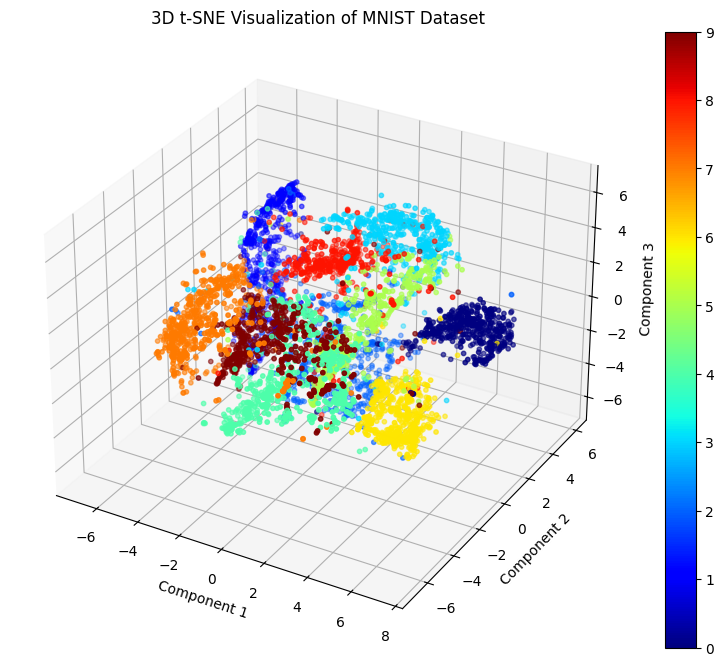

In [13]:
from mpl_toolkits.mplot3d import Axes3D

# Apply t-SNE with n_components=3
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30, max_iter=300)
X_embedded_3d = tsne_3d.fit_transform(X)


# Visualization
# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_embedded_3d[:, 0], X_embedded_3d[:, 1], X_embedded_3d[:, 2], c=y, cmap='jet', s=10)
plt.colorbar(scatter)
ax.set_title('3D t-SNE Visualization of MNIST Dataset')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.show()

## Implementing t-SNE using NUMPY

references : <br> https://www.dailydoseofds.com/formulating-and-implementing-the-t-sne-algorithm-from-scratch/ <br>
https://www.geeksforgeeks.org/students-t-distribution-in-statistics/

In [33]:
from scipy.spatial.distance import pdist, squareform

### Step - 1 Pairwise Affinities (PD) in High-Dimensional Space

1. Pairwise Squared Euclidean Distance <br>
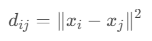

2. Gaussian Kernel <br>
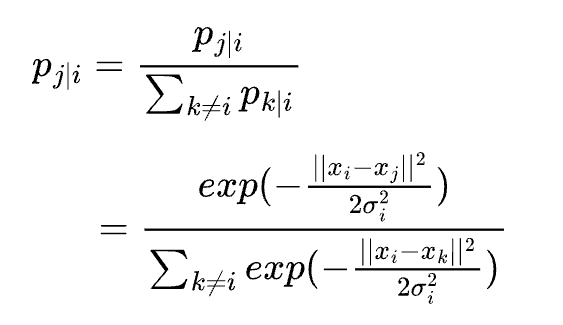

3. Symmetrize Probabilities <br>
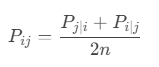

In [106]:
def compute_pairwise_affinities(X, perplexity=30):
    """
    Compute pairwise affinities (P_{j|i}) using a Gaussian kernel.
    """
    n = X.shape[0]
    distances = squareform(pdist(X, 'sqeuclidean'))  # Pairwise squared Euclidean distances
    affinities = np.zeros((n, n))

    for i in range(n):
        beta = binary_search_beta(distances[i], perplexity)
        affinities[i] = np.exp(-beta * distances[i])
        affinities[i, i] = 0  # Set diagonal to 0, data point can't be a neighbour to itself

    # Normalize row-wise to get conditional probabilities
    eps = 1e-10
    affinities /= np.sum(affinities, axis=1, keepdims=True) + eps  # Avoid NaNs

    # Symmetrize P matrix properly
    P = (affinities + affinities.T) / (2 * n)  # Normalize by 2n to get joint probabilities
    P = np.maximum(P, 1e-10)  # Ensure no zero values
    return P

### Step - 2 Binary Search for Optimal Variance 

1. Perplexity <br>
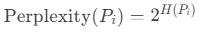

    $H(P_i)$ is the Shannon entropy of $P_i$ <br>
    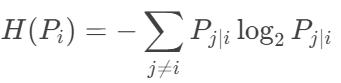

2. Binary Search <br>
    Adjust $σ_i$ until perplexity matches the desired value

In [97]:
def binary_search_beta(distances, perplexity, tol=1e-5, max_iter=50):
    """
    Perform binary search to find the optimal beta (precision) for a given perplexity.
    """
    n = len(distances)
    beta = 1.0  # Initialize beta
    beta_min, beta_max = None, None  # Initialize bounds
    target_entropy = np.log(perplexity)  # Natural log for consistency

    for _ in range(max_iter):
        # Compute probabilities
        probs = np.exp(-distances * beta)
        probs /= np.sum(probs) + 1e-10  # Avoid division by zero

        # Compute Shannon entropy
        entropy = -np.sum(probs * np.log(np.maximum(probs, 1e-10)))  # Use natural log

        # Check for convergence
        if np.abs(entropy - target_entropy) < tol:
            break

        # Adjust beta
        if entropy > target_entropy:
            beta_min = beta
            beta = beta * 2 if beta_max is None else (beta + beta_max) / 2
        else:
            beta_max = beta
            beta = beta / 2 if beta_min is None else (beta + beta_min) / 2

    return beta

### Step 3 Compute Pairwise Affinities in Low-Dimensional Space and Gradient of KL Divergence
In low-d space, we compute the probability of $Q_ij$ that point $y_i$ would pick $y_j$ as its neighbour using a heavy-tailed distribution(Student-t), this helps prevent crowding in low-dimensional space. <br>
The goal is to minimize the KL Divergence between the high-dimensional $(P_ij)$ and low-dimensikonal $(Q_ij)$ distributions.

1. Pairwise Squared Euclidean Distance (using the function defined above) <br>
2. Student-t Kernal <br>
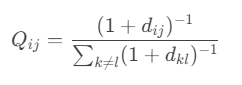

3. Gradient of KL Divergence <br>
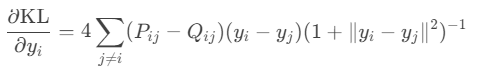

In [107]:
def tsne(X, n_components=2, perplexity=30, n_iter=4000, learning_rate=200, iter_plot=100, exaggeration_factor=12.0):
    """
    Perform t-SNE dimensionality reduction
    """
    n = X.shape[0]
    Y = np.random.randn(n, n_components) * 0.01  # Switched to a larger init

    P = compute_pairwise_affinities(X, perplexity)
    P *= exaggeration_factor  # Early exaggeration

    for iter in range(n_iter):
        # Compute pairwise affinities in low-dimensional space (Q_{ij})
        distances = squareform(pdist(Y, 'sqeuclidean')) + 1e-10  # to Avoid zero distance
        Q = (1 / (1 + distances))  # Student-t distribution
        np.fill_diagonal(Q, 0)  # No self-affinity
        Q /= np.sum(Q) + 1e-10  # Normalize

        # While debugging Gradient Norm, I noticed it was 0, this might be due to P and Q being identical
        # leading to the points not moving at all, so this is a check to add a small amount of noise to P if that's the case
        if np.allclose(P, Q, atol=1e-5):
            print("Warning: P and Q are identical! Adding noise.")
            P += np.random.normal(0, 1e-5, P.shape)

        # Compute gradient of KL divergence
        grad = np.zeros_like(Y)
        for i in range(n):
            diff = Y[i] - Y
            pq_diff = (P[i] - Q[i])[:, np.newaxis]  # Difference in probabilities
            q_weighted = Q[i][:, np.newaxis] * diff  # Weighted difference
            grad[i] = 4 * np.sum(pq_diff * q_weighted, axis=0)  # Correct force computation

        # Clip gradients to prevent divergence
        grad = np.clip(grad, -1, 1) 

        # Ensure gradients are nonzero before updating
        grad_norm = np.linalg.norm(grad) / n
        if grad_norm < 1e-6:
            print("Warning: Gradient norm too small! Adding noise.")
            grad += np.random.normal(0, 1e-5, grad.shape)

        # Update embedding
        Y -= learning_rate * grad

        # Gradually reduce exaggeration after 1000 iterations
        if iter == 1000:
            P /= exaggeration_factor

        # Visualize intermediate results and printing average gradient norm 
        if iter % iter_plot == 0:
            # Gradient
            print(f"Iteration {iter}: Avg Gradient Norm = {grad_norm:.6f}")

            # Scatter Plot of Data Points
            plt.scatter(Y[:, 0], Y[:, 1], c=y, cmap='jet', s=10)
            plt.title(f't-SNE Iteration {iter}')
            plt.show()

    return Y

## Application

In [ ]:
# I am reducing the dataset to 1000 digits as I have increased the iterations to a large amount
X = X[:1000].reshape(-1, 28*28)  # Flatten the images
y = y[:1000]

# Convert DataFrame/Series to NumPy arrays if necessary
if isinstance(X, pd.DataFrame):
    X = X.to_numpy()
if isinstance(y, pd.Series):
    y = y.to_numpy()

# Print shapes and unique labels for debugging
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique labels in y:", np.unique(y))

# Apply t-SNE
Y = tsne(X, n_components=2, perplexity=10, n_iter=300, learning_rate=10, iter_plot=50)

# Final visualization
plt.scatter(Y[:, 0], Y[:, 1], c=y, cmap='jet', s=10)
plt.title('t-SNE Visualization of MNIST Dataset')
plt.colorbar(label='Digit Class')
plt.show()

It's evident that there are no distinct clusters

### Standardizing the Input and Applying PCA before applying t-SNE

Dataset Sparsity: 80.91%
Explained variance after PCA: 0.77
Dataset Sparsity: 0.00%
X shape: (5000, 100)
y shape: (5000,)
Unique labels in y: [0 1 2 3 4 5 6 7 8 9]
First row of X: [-1.18381855 -4.74664839 -0.61763683  7.37635636  1.6657912   1.53082073
  0.62221327  1.03759013  0.72285636  0.23376638 -0.55336067  6.46349742
  7.3446564   5.76321697 -2.05833875 -3.84645162  5.74337177  0.06517874
 -2.59820176 -2.2907536   2.31709144  8.33515475  1.90819468  2.50719413
  1.8639717  -3.56474757  2.07349756  2.41063466 -2.62662027  0.64660426
 -0.12558784  2.94322121  3.0074267  -0.78041887  1.71072105  1.30453391
  2.46280092  1.44651225 -1.05999659  0.08568539 -3.90249162  2.83584064
  3.30820604 -2.45148413 -1.6576301  -0.96835436  1.93122367 -2.33562341
  0.63233189 -1.80770742  0.41580011 -0.82182605 -1.29599706  3.38930437
  1.50791493  0.87424146 -0.94377231  2.34593542 -1.33398519 -2.23880991
  1.24748667  0.02580645 -0.25952237  0.988816   -0.29711344  0.59349234
  1.93071029 -1.6

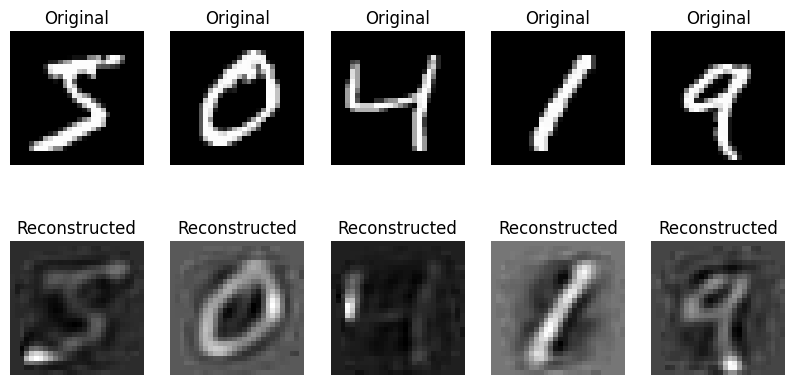

In [119]:
# MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"].astype(int)

# Using only a subset of the dataset to help compute faster
X = X[:5000]
y = y[:5000]

sparsity = np.mean(X == 0)
print(f"Dataset Sparsity: {sparsity * 100:.2f}%")

# Converting Data to NumPy
import pandas as pd
if isinstance(X, pd.DataFrame):
    X = X.to_numpy()
if isinstance(y, pd.Series):
    y = y.to_numpy()

# Premptive measure as the data might not be centered
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=100, random_state=42) # Hopefully this reduces the sparcity as well
X_reduced = pca.fit_transform(X_scaled)

# Check on the Variance Explained to Confirm Proper PCA
explained_variance = sum(pca.explained_variance_ratio_)
print(f"Explained variance after PCA: {explained_variance:.2f}")

sparsity = np.mean(X_reduced == 0)
print(f"Dataset Sparsity: {sparsity * 100:.2f}%")

print("X shape:", X_reduced.shape)  # Check shape
print("y shape:", y.shape)  # Check shape
print("Unique labels in y:", np.unique(y))  # Check class distribution
print("First row of X:", X_reduced[0])  # Check if X has valid numerical data

# Reconstruct images
X_reconstructed = pca.inverse_transform(X_reduced)

# Visualize original vs reconstructed images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i in range(5):
    axes[0, i].imshow(X[i].reshape(28, 28), cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')
    axes[1, i].imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis('off')
plt.show()

Iteration 0: Avg Gradient Norm = 0.000000


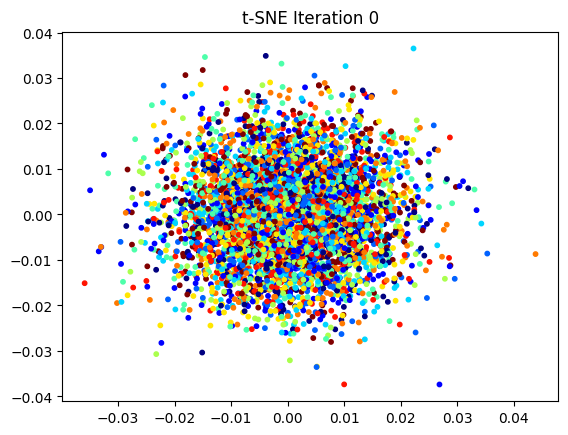

In [ ]:
# Going with a lower perplexity and higher iterations and a much lower learning rate
Y = tsne(X_reduced, n_components=2, perplexity=10, n_iter=4000, learning_rate=200, iter_plot = 200)

# Final Plot
plt.figure(figsize=(8,6))
plt.scatter(Y[:, 0], Y[:, 1], c=y, cmap='jet', s=10, alpha=0.7)
plt.colorbar()
plt.title("t-SNE Visualization of MNIST Dataset")
plt.show()